In [1]:
from display import display_figures

from include.load_data import get_counts

from include.optim_tools import slidingMAD

from include.estim import Rt_MLE as estimMLE
from include.estim import Rt_Cori as estimCori
from include.estim import Rt_Univariate as estimU
from include.estim import Rt_UnivariateOutliers as estimUO

from include.estim import Rt_Multivariate as estimM
from include.estim import Rt_MultivariateOutliers as estimMO

## Univariate reproduction number estimations on real-world infection counts
### Data fetching

dataBasis choice between `SPF` (Santé Publique France) and `JHU` (Johns Hopkins University)
&nbsp;
country choice should only be
   * `France` for `SPF`
   * any country available at https://coronavirus.jhu.edu/data for `JHU`

Opening data from Johns Hopkins University.


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


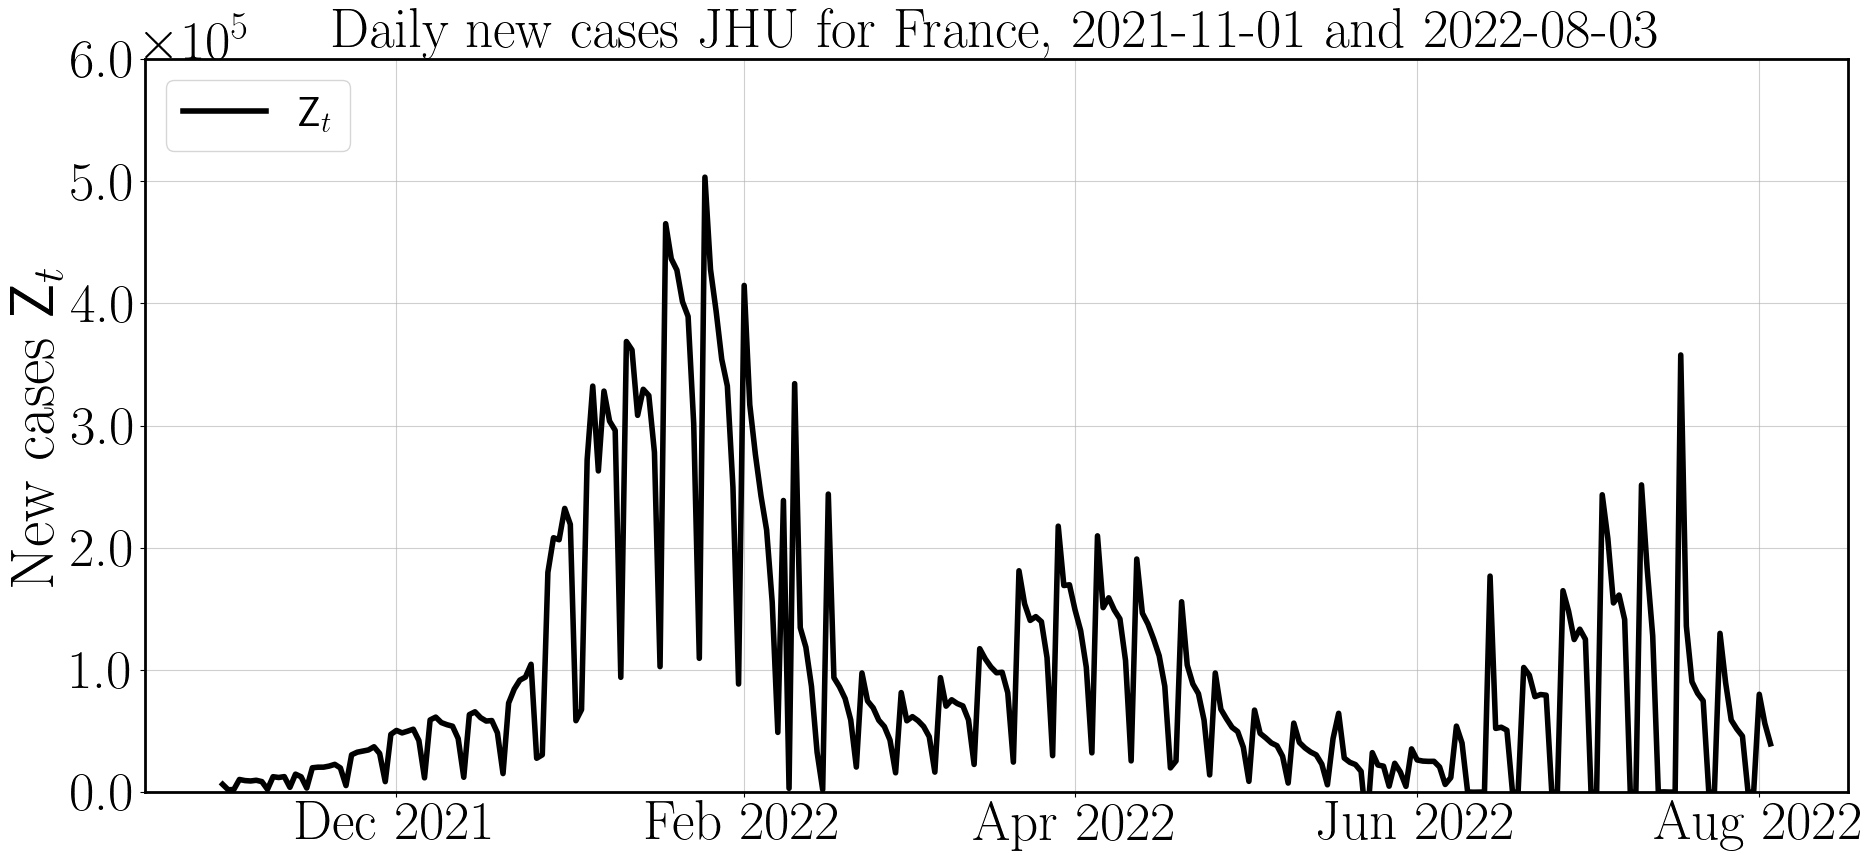

In [2]:
# Choice of country, dates, regularization parameters & computation
dataBasis = 'JHU'
country = 'France'
firstDay = '2021-11-01'  # first day of the chosen time period
lastDay = '2022-08-03'  # last day of the chosen time period

# Fetch data and associated dates
dates, data = get_counts.get_real_counts(country, firstDay, lastDay, dataBasis)
fig, axes, formattedDates = display_figures.display_data(dates, data, "Daily new cases %s for %s, %s and %s" % (dataBasis, country, firstDay, lastDay))

### Maximum Likelihood Estimator
* $\mathsf{R}^{\mathsf{MLE}} \in \mathrm{arg\,min}_{\mathsf{R} \in \mathbb{R}^{\mathsf{T}}} -\ln \mathsf{Likelihood}(\mathsf{Z}^{\mathsf{denoised}}, \mathsf{R})$

Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


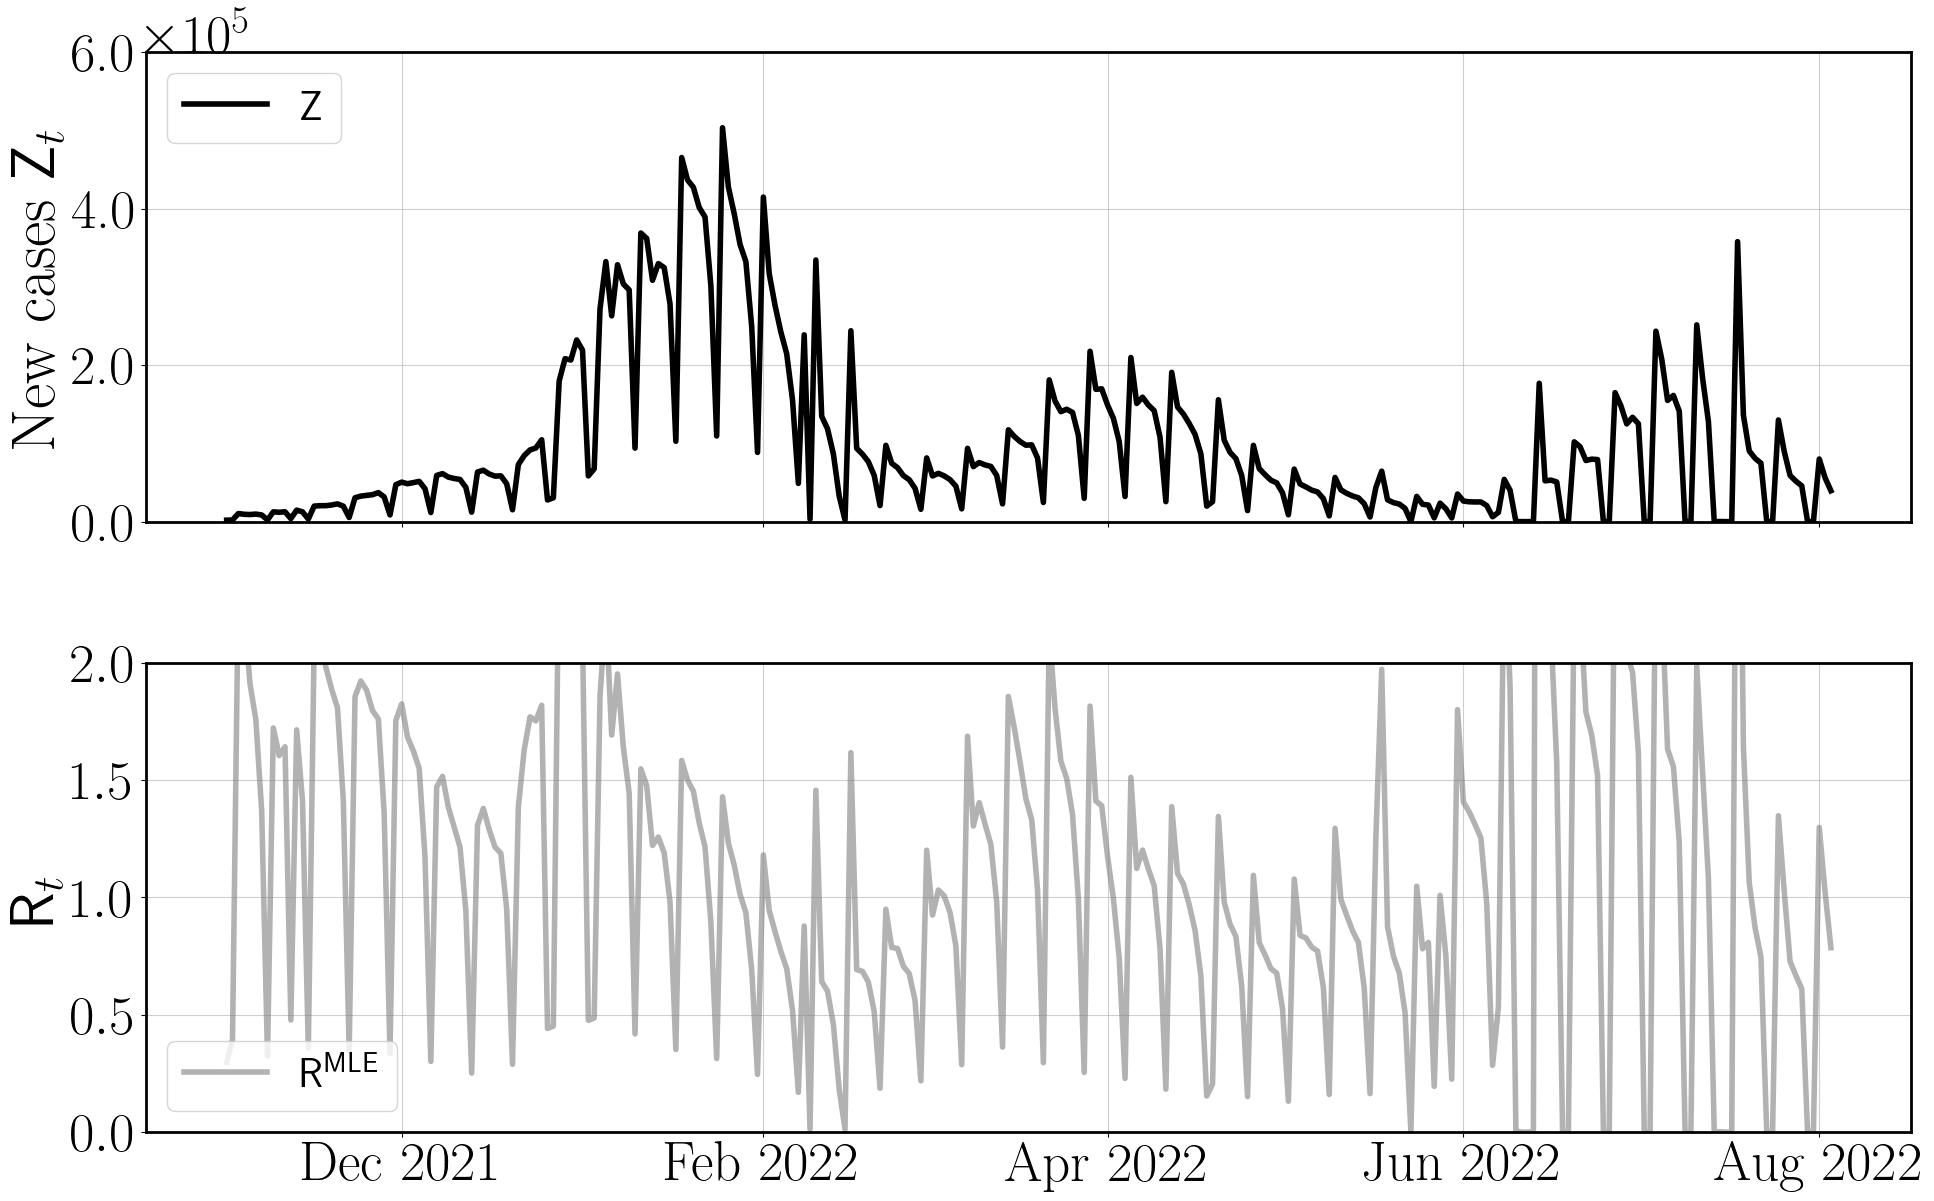

In [3]:
# Analytic computation
R_MLE, datesMLE, dataMLE = estimMLE.Rt_MLE(dates, data)

# Display figures
figMLE, axesMLE, formattedDatesMLE = display_figures.display_REstim(datesMLE, dataMLE, R_MLE, 'MLE', dataUnder=True)

### Cori Estimator

Following the article "A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics", Cori et al., 2013, Am. Journal of Epidemiology, R estimation is made using Bayesian framework resulting in:

&nbsp;
$\mathsf{R}^{\mathsf{Cori}} = \frac{1 + \sum_{s=t-\tau}^{t}\mathsf{Z}_s}{5 + \sum_{s=t-\tau}^{t}(\Phi\star\mathsf{Z})_s}$

Here $\tau = 15$

Computing Cori's method estimation (C) ...
Done in 0.0030 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


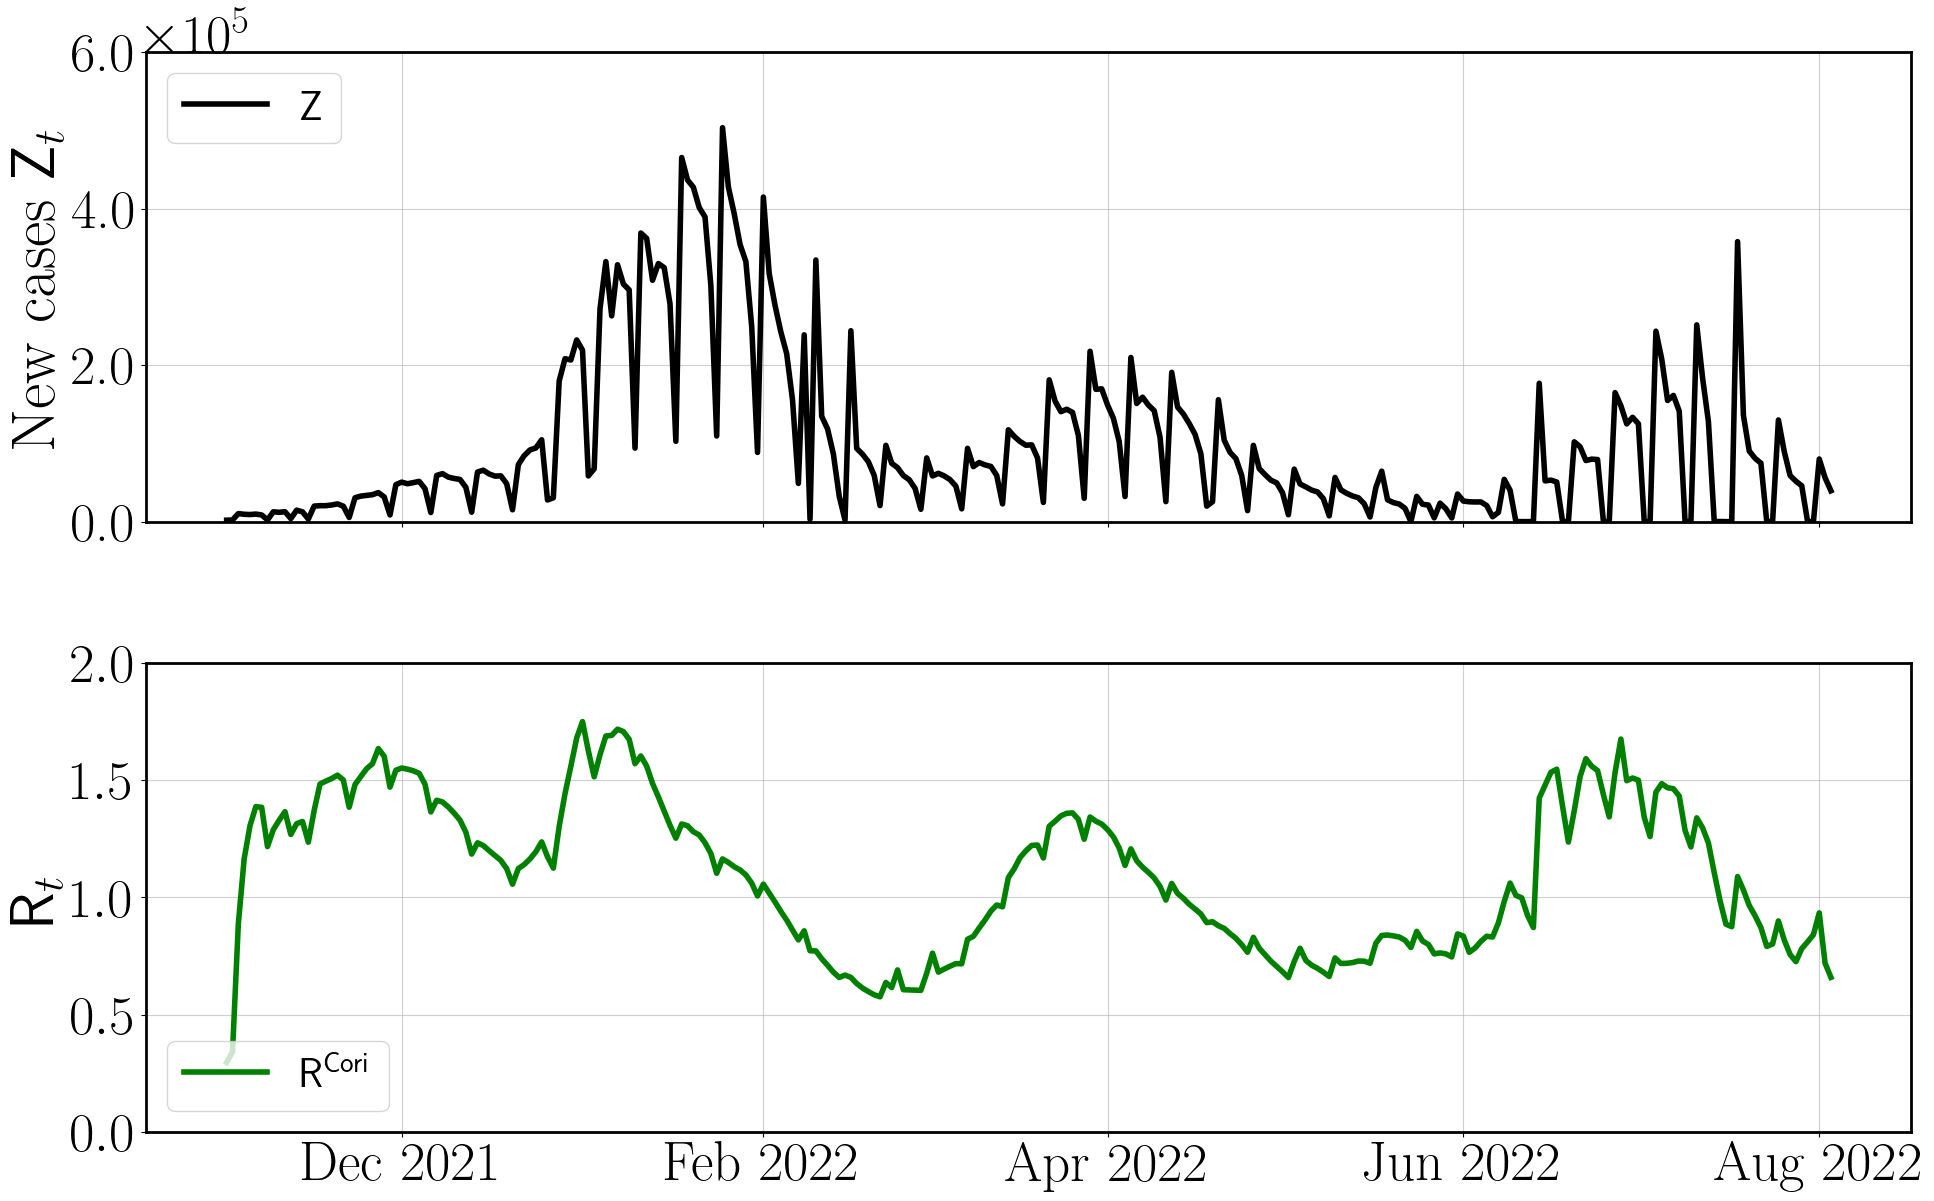

In [4]:
# Analytic computation
R_Cori, datesCori, dataCori = estimCori.Rt_C(dates, data)

# Display results
figCori, axesCori, formattedDatesCori = display_figures.display_REstim(datesCori, dataCori, R_Cori, 'Cori', dataUnder=True)

### Penalized Likelihood estimation

1. $\mathsf{Z}^{\mathsf{denoised}} = \mathsf{slidingMAD}(\mathsf{Z}, \alpha)$
    &nbsp;

    with sliding Median Absolute Deviation (MAD) that can be tuned using $\alpha \geq 0$:
    - small $\alpha$ : lot of data denoised
    - great $\alpha$ : few data denoised

2. Solving the Penalized Likelihood functional with Chambolle-Pock algorithm
    &nbsp;
   $\mathsf{R}^{\mathsf{PL}} \in \mathrm{arg\,min}_{\mathsf{R} \in \mathbb{R}^{\mathsf{T}}} -\ln \mathsf{Likelihood}(\mathsf{Z}^{\mathsf{denoised}}, \mathsf{R}) +\mu_\mathsf{R} \|\boldsymbol{\mathsf{D}}_2\mathsf{R}\|_1$

Computing Penalized Log-likelihood + Graph (PLG) ...
Done in 4.9741 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


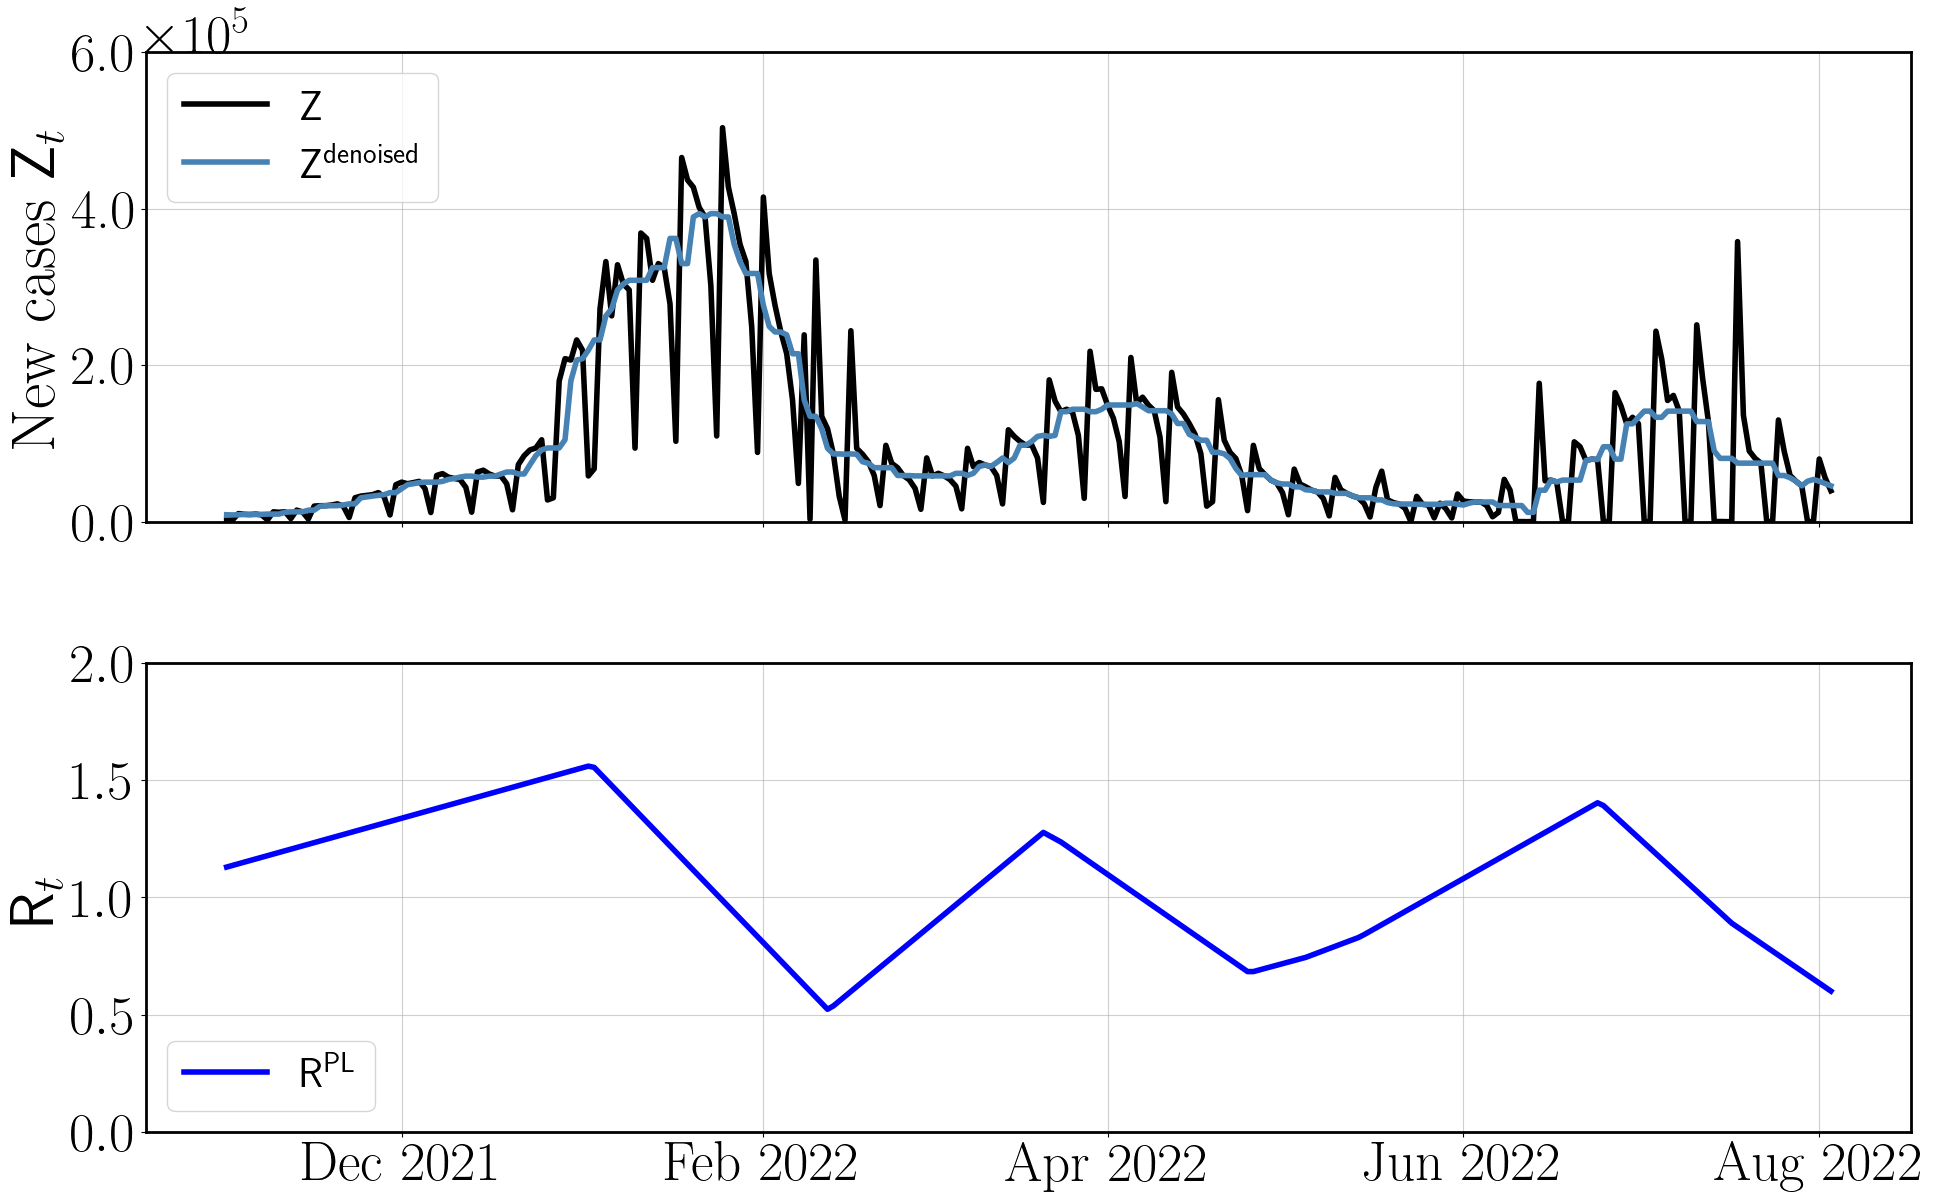

In [5]:
# from include.estim import Rt_U_M as estimPL
# Choice of denoising parameter alpha and regularization parameter muR
alpha = 0.1
muR = 50

# Denoising with sliding MAD then solving with Chambolle-Pock algorithm
denoisedData = slidingMAD.slidingMAD(data, alpha)
R_PL, datesPL, denoisedDataPL = estimU.Rt_Univariate(dates, denoisedData, muR=muR)

# Display results
dataCropped = data[1:]  # data[0] is used for burn-in
figPL, axesPL, formattedDatesPL = display_figures.display_REstim(datesPL, dataCropped, R_PL, 'PL', OEstimate=dataCropped - denoisedDataPL, dataUnder=True)

### Joint estimation

Solving the following Joint penalized likelihood functional using Chambolle-Pock algorithm
&nbsp;
$\mathsf{R}^{\mathsf{Joint}}, \mathsf{O}^{\mathsf{Joint}} \in \mathrm{arg\,min}_{\mathsf{R}, \mathsf{O} \in \mathbb{R}^{\mathsf{T}}} -\ln \mathsf{Likelihood}(\mathsf{Z}, \mathsf{R}, \mathsf{O}) +\lambda_\mathsf{R} \|\boldsymbol{\mathsf{D}}_2\mathsf{R}\|_1 + \lambda_\mathsf{O} \|\mathsf{O}\|_1$

* A greater $\lambda_R$ means less slope ruptures
* A greater $\lambda_O$ means less denoising
&nbsp;

* For examples, see settings.RegularizationSettings

Computing Joint estimation + Graph (JG) ...
iter 100000.000000 	 crit=3.021424 

Done in 39.2315 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


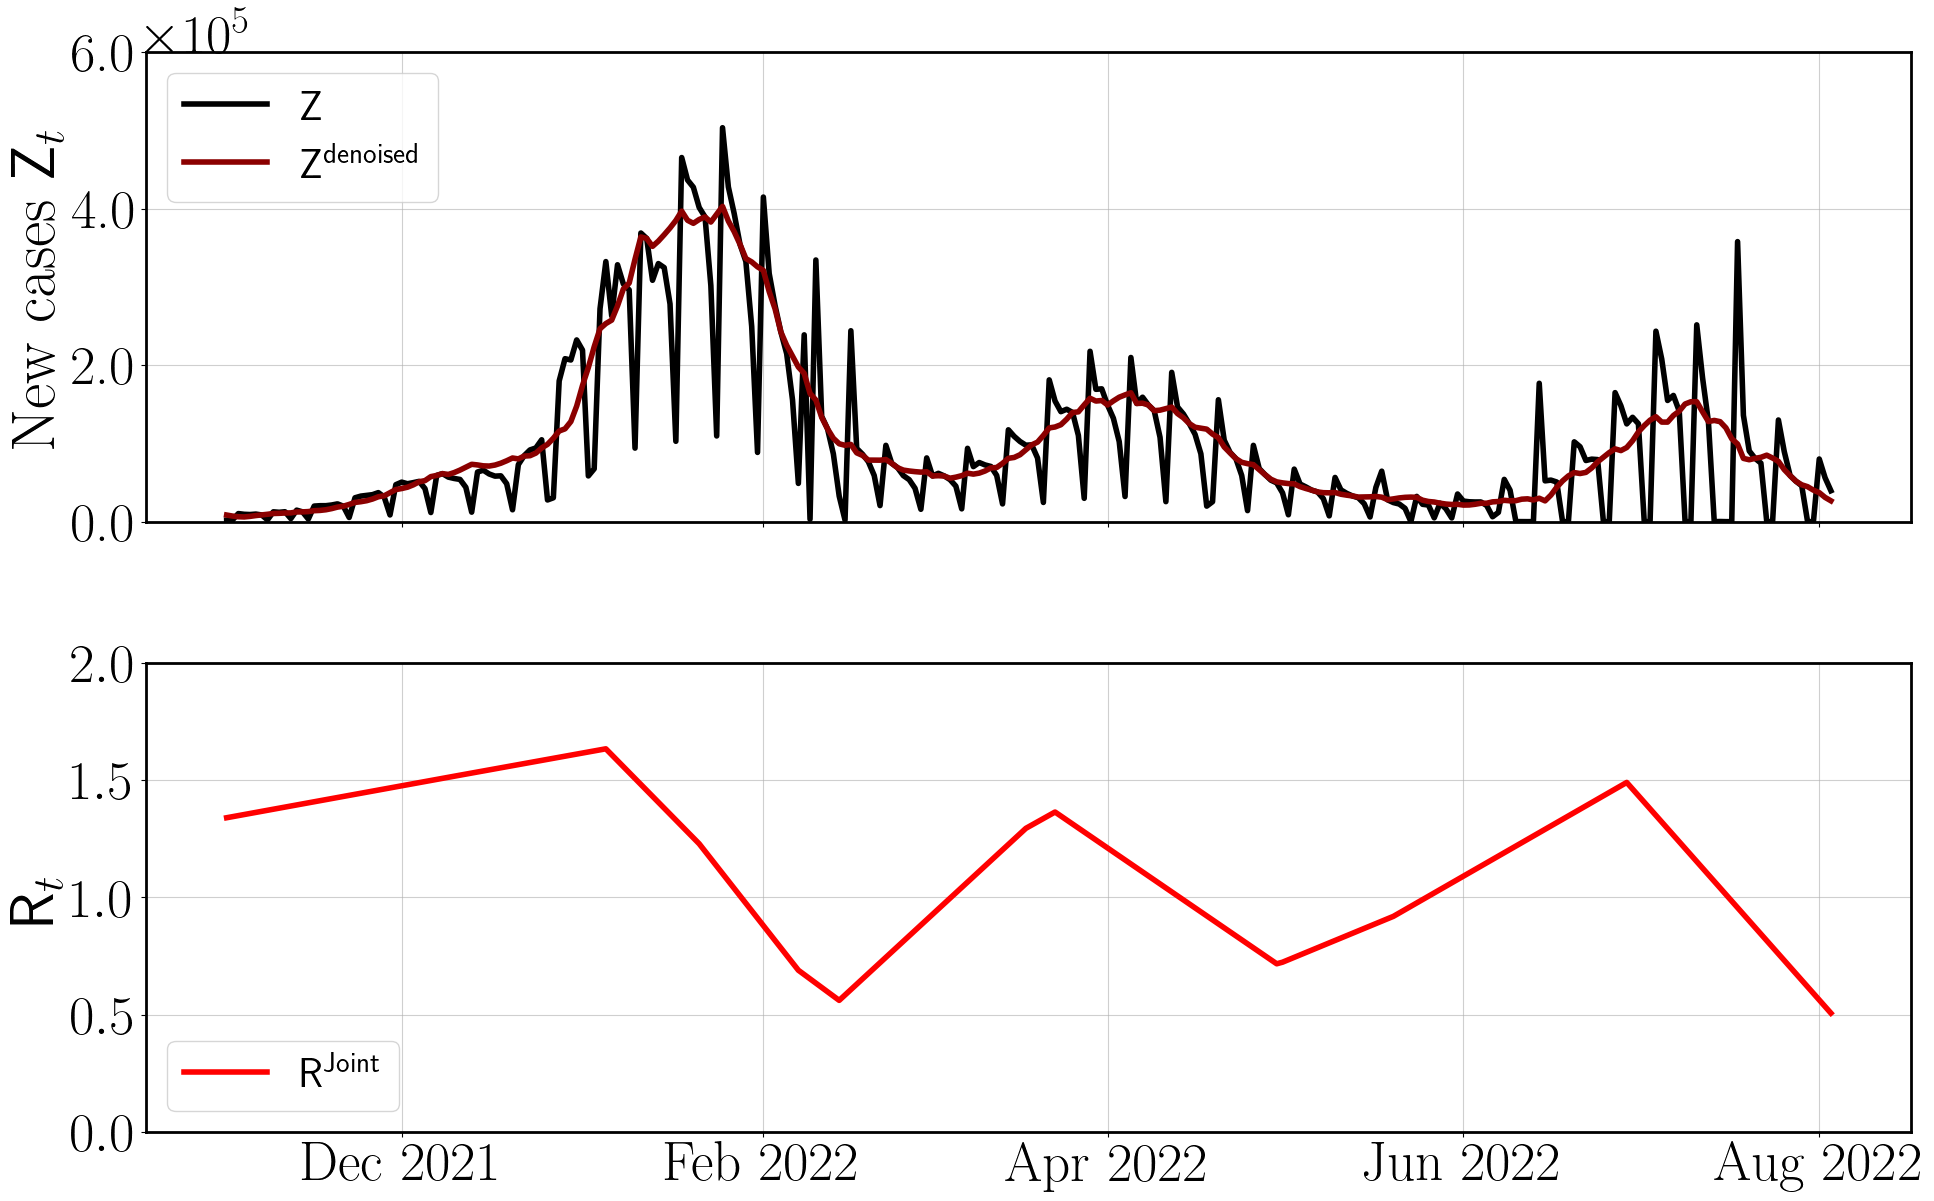

In [6]:
# Choice of denoising parameter alpha and regularization parameter muR
lambdaR = 3.5
lambdaO = 0.03

# Other options
# lambdaR = 50
# lambdaO = 0.75

# Solving with Chambolle-Pock algorithm
R_Joint, O_Joint, datesJ, dataJ = estimUO.Rt_Univariate_Outliers(dates, data, lambdaR=lambdaR, lambdaO=lambdaO)

# Display results
figJoint, axesJoint, formattedDatesJoint = display_figures.display_REstim(datesJ, dataJ, R_Joint, 'Joint', OEstimate=O_Joint, dataUnder=True)

C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


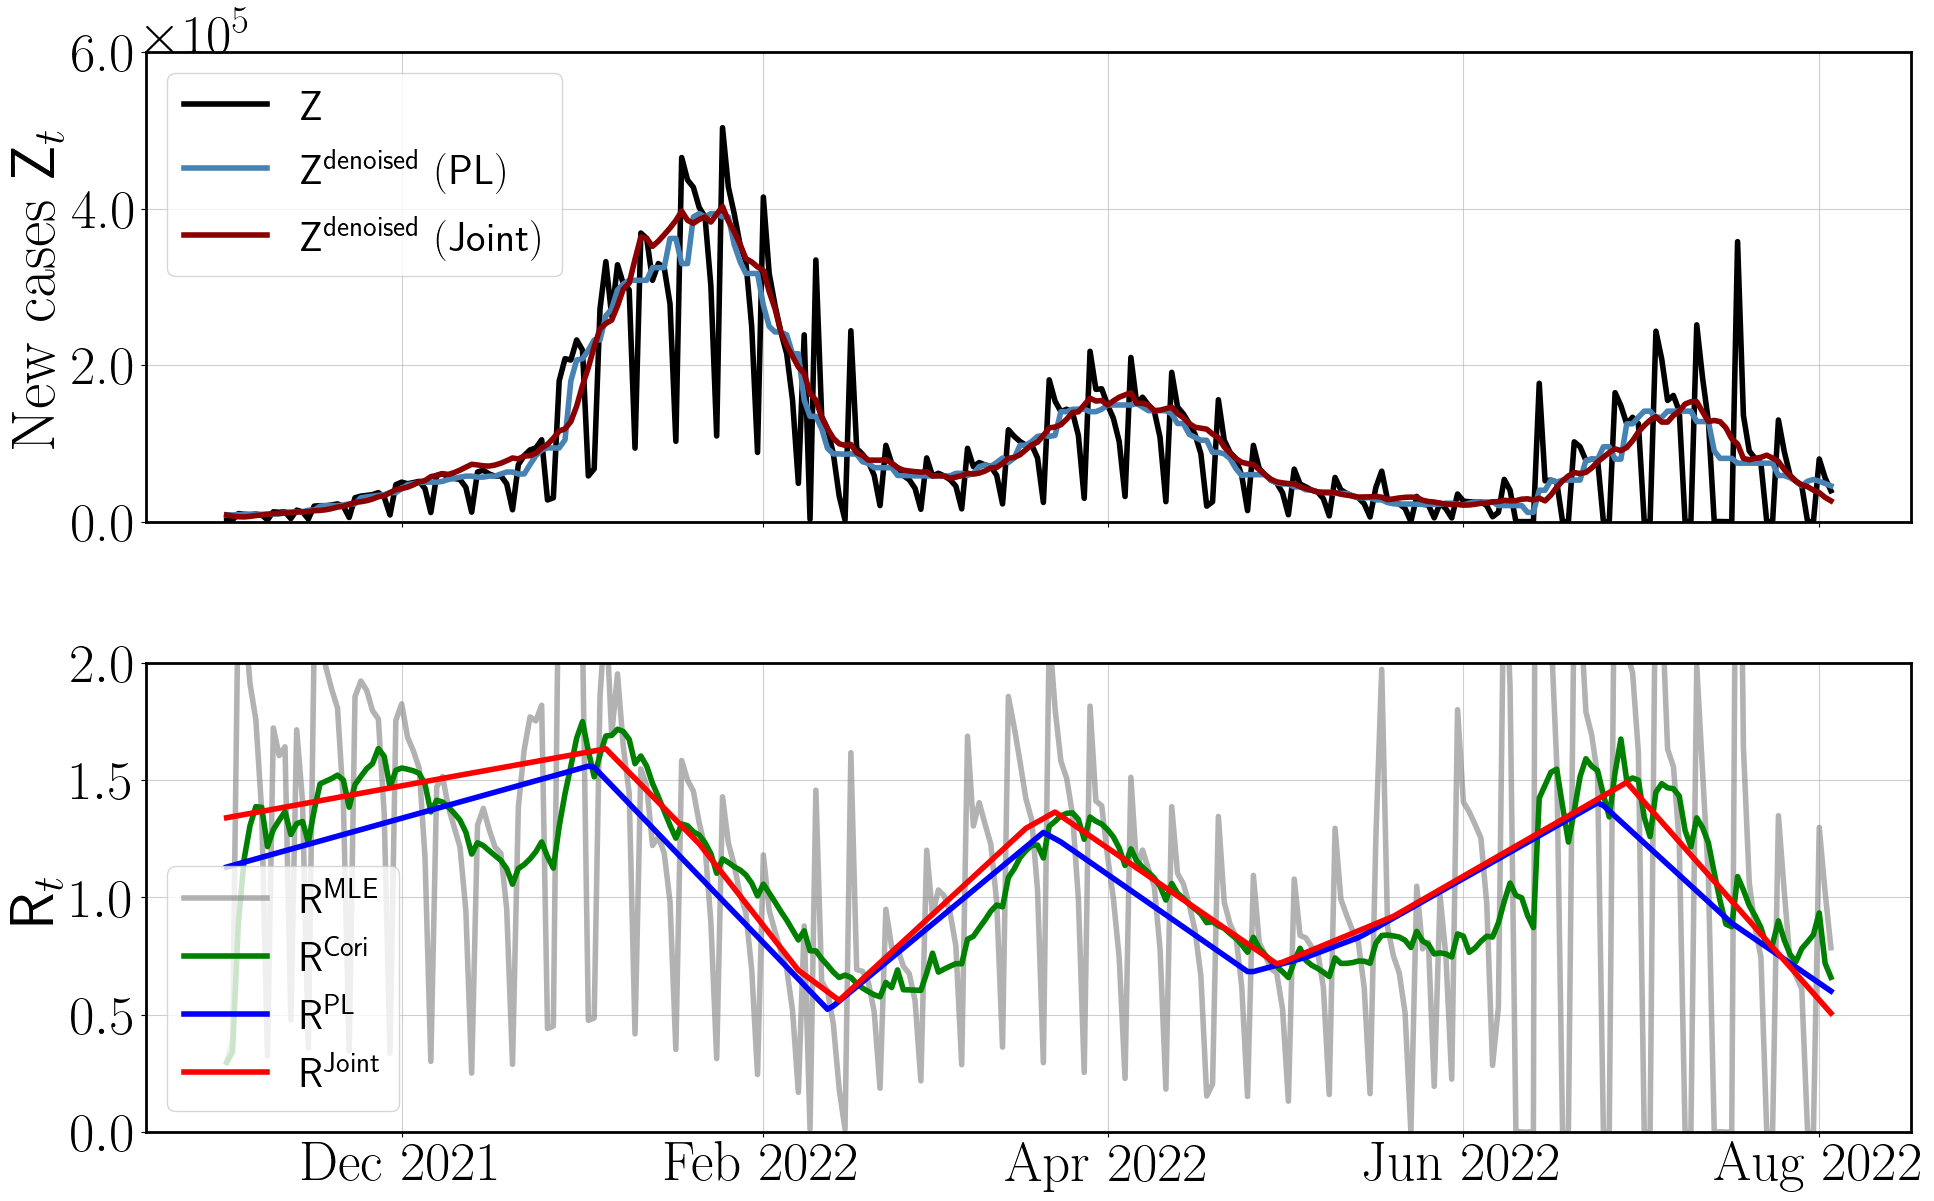

In [7]:
# Gather all methods
methods = ['MLE', 'Cori', 'PL', 'Joint']
REstimations = {'MLE': R_MLE,
                'Cori': R_Cori,
                'PL': R_PL,
                'Joint': R_Joint}

OEstimations = {'PL': dataCropped - denoisedDataPL,
                'Joint': O_Joint}

# Display comparison between methods
figComp, axesComp, formattedDatesComp = display_figures.display_REstim(datesJ, dataJ, REstimations, methods, OEstimate=OEstimations, comparison=True, dataUnder=True)

## Multivariate reproduction number estimations on real-world infection counts